## read Bepi data







In [1]:
import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import  DateFormatter
from datetime import timedelta
import seaborn as sns
import datetime
import astropy
import astropy.constants as const
from sunpy.time import parse_time
import time
import pickle
import sys
import os
import urllib
import json
import importlib
import pandas as pd
import copy
import openpyxl
import h5py
import heliopy.data.spice as spicedata
import heliopy.spice as spice
import heliosat


from heliocats import plot as hp
importlib.reload(hp) #reload again while debugging

from heliocats import data as hd
importlib.reload(hd) #reload again while debugging

from heliocats import cats as hc
importlib.reload(hc) #reload again while debugging

from heliocats import stats as hs
importlib.reload(hs) #reload again while debugging

#where the in situ data files are located is read 
#from config.py 
import config
importlib.reload(config)
from config import data_path
from config import data_path_ML


########### make directories first time if not there
resdir='results'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

indexdir='icmecat/indices_icmecat' 
if os.path.isdir(indexdir) == False: os.mkdir(indexdir) 

catdir='icmecat'
if os.path.isdir(catdir) == False: os.mkdir(catdir)

icplotsdir='icmecat/plots_icmecat/' 
if os.path.isdir(icplotsdir) == False: os.mkdir(icplotsdir) 

plt.rcParams["figure.figsize"] = (15,5)

from astropy.constants import au
#define AU in km
AU=au.value/1e3
print('done')

raw_data_path='/nas/helio/data/BepiColombo/cruise_ob/'


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
done


## get Wind data

In [2]:
filewin=data_path+'wind_2018_now_gse.p'
[win,hwin]=pickle.load(open(filewin, "rb" ) )


filewin2="wind_2018_now_heeq.p" 
[win2,hwin2]=pickle.load(open(data_path+filewin2, "rb" ) )  

#remove Wind spikes with spike list data/wind_spikes.txt
spike_ind=[]
wind_spikes_file = open("data/wind_spikes.txt", "r")
wind_spikes = parse_time(wind_spikes_file.read().splitlines()).datetime
#get the indices of the spikes in the wind data
spike_ind=[np.where(wind_spikes[i]==win.time)[0][0] for i in np.arange(0,len(wind_spikes))]
#remove spikes
win.time[spike_ind]=np.nan


#set wind awkward data points to nan
#windspike_ind=np.where(win.time > parse_time('2020-04-20 17:08').datetime)[0]
#win.bt[windspike_ind[0:2]]=np.nan
#win.bx[windspike_ind[0:2]]=np.nan
#win.by[windspike_ind[0:2]]=np.nan
#win.bz[windspike_ind[0:2]]=np.nan


#set wind awkward data points to nan
#windspike_ind=np.where(win.time > parse_time('2020-04-21 01:20').datetime)[0]
#win.bt[windspike_ind[0:1]]=np.nan
#win.bx[windspike_ind[0:1]]=np.nan
#win.by[windspike_ind[0:1]]=np.nan
#win.bz[windspike_ind[0:1]]=np.nan

In [91]:
#########test conversions


#andi method
filetesta="bepi_rtn_nov_dec_2020.p" 
tba=pickle.load(open('data/'+filetesta, "rb" ) )  

#chris method
filetestc="bepi_2019_2021_rtn.p" 
tbc=pickle.load(open(data_path+filetestc, "rb" ) )  

filetestce="bepi_2019_2021_e2k.p" 
tbce=pickle.load(open(data_path+filetestce, "rb" ) )  

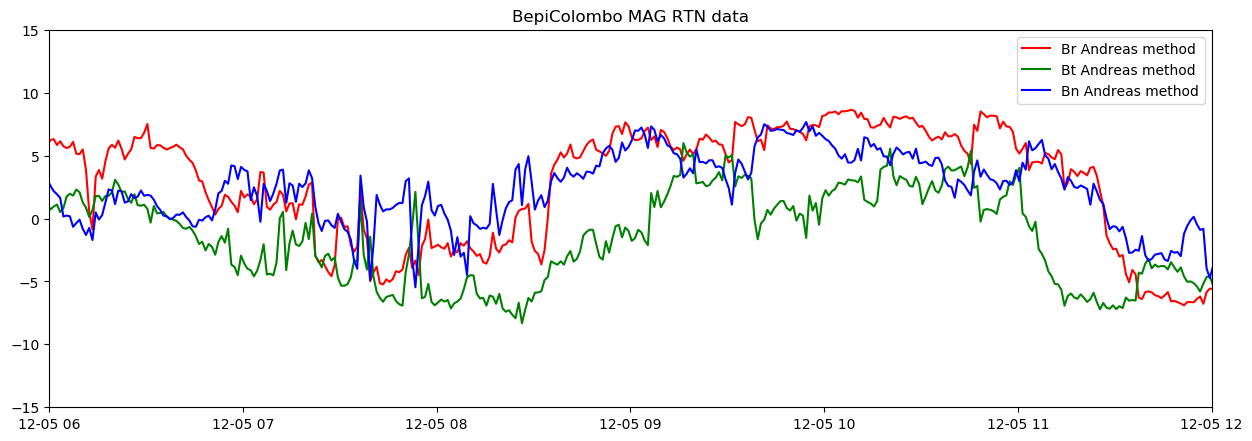

In [92]:

filetesta="bepi_rtn_nov_dec_2020.p" 
tba=pickle.load(open('data/'+filetesta, "rb" ) )  

plotstart=datetime.datetime(2020,12,5,6)
plotend=datetime.datetime(2020,12,5,12)

#plotstart=datetime.datetime(2020,4,20,6)
#plotend=datetime.datetime(2020,4,20,12)

plt.figure(1,figsize=(15,5),dpi=100)
plt.plot(tba['dt'], tba['bt'][:,0],color='red',label='Br Andreas method')
plt.plot(tba['dt'], tba['bt'][:,1],color='green',label='Bt Andreas method')
plt.plot(tba['dt'], tba['bt'][:,2],color='blue',label='Bn Andreas method')

plt.title('BepiColombo MAG RTN data')

plt.xlim(plotstart, plotend)
plt.ylim(-15,15)
plt.legend(loc=1)


#plt.plot(tbc.time, tbc.bx, color='red', lw=1, ls='--',label='Br Chris method')
#plt.plot(tbc.time, tbc.by, color='green', lw=1, ls='--',label='Bt Chris method')
#plt.plot(tbc.time, tbc.bz, color='blue', lw=1, ls='--',label='Bn Chris method')


#plt.plot(win2.time, win2.bx, color='red', lw=1, ls='--',label='Wind Bx HEEQ')
#plt.plot(win2.time, win2.by, color='green', lw=1, ls='--',label='Wind By HEEQ')
#plt.plot(win2.time, win2.bz, color='blue', lw=1, ls='--',label='Wind Bz HEEQ')


#plt.plot(tbce.time, tbce.bxe, color='red', lw=1, ls='dotted', label='Bx original E2K data')
#plt.plot(tbce.time, tbce.bye, color='green', lw=1, ls='dotted', label='By original E2K data')




#plt.xlim(plotstart, plotend)
#plt.ylim(-15,15)
#plt.legend(loc=1)

## read all Bepi Colombo MPO/MAG cruise data

## inbound

In [2]:
#get data from IB SENSOR, ECLIPJ2000

raw_data_path_ib='/nas/helio/data/BepiColombo/cruise_ib/'

filelist_all=os.listdir(raw_data_path_ib)
#only tab files
filelist = [i for i in filelist_all if i.endswith('.tab')]
filesort=np.sort(filelist)

#start with March 1 2020 
#filesort=filesort[346:]

#set time range for 1 minute interpolation
t_start = datetime.datetime(2021, 8, 3)
t_end = datetime.datetime(2021, 10, 3)

#t_start = datetime.datetime(2020, 10, 6)
#t_end = datetime.datetime(2020, 11, 16)



#make array 
bm=np.zeros(86400*len(filelist),dtype=[('time',object),('bx', float),('by', float),\
        ('bz', float),('x', float),('y', float),('z', float)])  
bm = bm.view(np.recarray) 
               
counter=0            

#x y z
#SC POSITION X COMPONENT, ECLIPJ2000 COORDINATES. VALUE IS GIVEN IN KM. THE SC POSITION IS STATED AS THE DISTANCE TO SUN.
#MAGNETIC FIELD X COMPONENT, 1-SECOND-AVERAGED CALIBRATED DATA,   ECLIPJ2000 COORDINATES, OB SENSOR. VALUE IS GIVEN IN NANOTESLA.

#go through all files
for file in filesort:
    print(file)
    braw=np.loadtxt(raw_data_path_ib+file,delimiter=",",dtype=[('time','<U30'),('tsc','<U30'),('x', float),\
                                            ('y', float),('z', float),('bx', float),('by', float),\
                                            ('bz', float),('t1', float),('t2', float),('t3', float)])
    braw = braw.view(np.recarray) 
            
    bm.time[counter:counter+len(braw)]=parse_time(braw.time).datetime
    bm.bx[counter:counter+len(braw)]=braw.bx
    bm.by[counter:counter+len(braw)]=braw.by
    bm.bz[counter:counter+len(braw)]=braw.bz

    bm.x[counter:counter+len(braw)]=braw.x
    bm.y[counter:counter+len(braw)]=braw.y
    bm.z[counter:counter+len(braw)]=braw.z


    counter=counter+len(braw)

bm1=bm[0:counter]

#------------------------------------------- interpolate to 1 minute

# create an array with 1 minute resolution between t start and end
time = [ t_start + datetime.timedelta(minutes=1*n) for n in range(int ((t_end - t_start).days*60*24))]
time_mat=mdates.date2num(time) 

bmag=np.zeros(np.size(time_mat),dtype=[('time',object),('bx', float),('by', float),\
        ('bz', float),('bt', float),('bxe', float),('bye', float), ('bze', float),\
        ('xe', float),('ye', float),('ze', float),\
        ('x', float),('y', float),('z', float),\
        ('r', float),('lat', float),('lon', float)])  
bmag = bmag.view(np.recarray) 

tm_mat=mdates.date2num(bm1.time) 

bmag.time=time
bmag.bxe = np.interp(time_mat, tm_mat, bm1.bx)
bmag.bye = np.interp(time_mat, tm_mat, bm1.by)
bmag.bze = np.interp(time_mat, tm_mat, bm1.bz)
#bmag.bt =np.sqrt(bmag.bxe**2+bmag.bye**2+bmag.bze**2)




#round first each original time to full minutes
tround=copy.deepcopy(bm1.time)
format_str = '%Y-%m-%d %H:%M'  
for k in np.arange(np.size(bm1.time)):
     tround[k] = datetime.datetime.strptime(datetime.datetime.strftime(bm1.time[k], format_str), format_str) 
tm_round=parse_time(tround).plot_date

isin=np.isin(time_mat,tm_round)      
setnan=np.where(isin==False)
#set to to nan that is not in original data
bmag.bxe[setnan]=np.nan
bmag.bye[setnan]=np.nan
bmag.bze[setnan]=np.nan
bmag.bt = np.sqrt(bmag.bxe**2+bmag.bye**2+bmag.bze**2)




# old with heliopy bepi position in HEEQ
#frame='HEEQ'
#spice.furnish(spicedata.get_kernel('bepi_pred'))
#traheeq=spice.Trajectory('BEPICOLOMBO MPO')
#traheeq.generate_positions(time,'Sun',frame)
#traheeq.change_units(astropy.units.AU)  
#[bmag.r, bmag.lat, bmag.lon]=hd.cart2sphere(traheeq.x,traheeq.y,traheeq.z)

# convert to degree
#bmag.lat=np.rad2deg(bmag.lat)
#bmag.lon=np.rad2deg(bmag.lon)

#bmag.x=traheeq.x.value
#bmag.y=traheeq.y.value
#bmag.z=traheeq.z.value

print('Bepi position')
bepi_pos=heliosat.BEPI().trajectory(time, frame="HEEQ")
bmag.x=bepi_pos[:,0]
bmag.y=bepi_pos[:,1]
bmag.z=bepi_pos[:,2]
[bmag.r, bmag.lat, bmag.lon]=hd.cart2sphere(bepi_pos[:,0],bepi_pos[:,1],bepi_pos[:,2])
bmag.lon=np.rad2deg(bmag.lon) #convert to degree
bmag.lat=np.rad2deg(bmag.lat)


print('done')


####################### save Bepi HEEQ positions and EK2 components data
filemag=data_path+'bepi_2021_ib_e2k.p'
pickle.dump(bmag, open(filemag, "wb"))


######################### convert E2K to HEE
bmage=hd.convert_E2K_to_HEE(bmag)
filemag=data_path+'bepi_2021_ib_hee.p'
pickle.dump(bmage, open(filemag, "wb"))


######################### convert HEE to HEEQ
bmagq=hd.convert_HEE_to_HEEQ(bmage)
filemag=data_path+'bepi_2021_ib_heeq.p'
pickle.dump(bmagq, open(filemag, "wb"))


######################### convert HEEQ to RTN

bmagrtn=hd.convert_HEEQ_to_RTN(bmagq)
filemag=data_path+'bepi_2021_ib_rtn.p'
pickle.dump(bmagrtn, open(filemag, "wb"))


######################### convert HEEQ to SCEQ
bmags=hd.convert_HEEQ_to_SCEQ(bmagq)
filemag=data_path+'bepi_2021_ib_sceq.p'
pickle.dump(bmags, open(filemag, "wb"))





mag_der_sc_ib_a001_e2k_00000_20210803.tab
mag_der_sc_ib_a001_e2k_00000_20210804.tab
mag_der_sc_ib_a001_e2k_00000_20210805.tab
mag_der_sc_ib_a001_e2k_00000_20210806.tab
mag_der_sc_ib_a001_e2k_00000_20210813.tab
mag_der_sc_ib_a001_e2k_00000_20210814.tab
mag_der_sc_ib_a001_e2k_00000_20210815.tab
mag_der_sc_ib_a001_e2k_00000_20210816.tab
mag_der_sc_ib_a001_e2k_00000_20210817.tab
mag_der_sc_ib_a001_e2k_00000_20210818.tab
mag_der_sc_ib_a001_e2k_00000_20210819.tab
mag_der_sc_ib_a001_e2k_00000_20210823.tab
mag_der_sc_ib_a001_e2k_00000_20210824.tab
mag_der_sc_ib_a001_e2k_00000_20210825.tab
mag_der_sc_ib_a001_e2k_00000_20210826.tab
mag_der_sc_ib_a001_e2k_00000_20210827.tab
mag_der_sc_ib_a001_e2k_00000_20210828.tab
mag_der_sc_ib_a001_e2k_00000_20210829.tab
mag_der_sc_ib_a001_e2k_00000_20210830.tab
mag_der_sc_ib_a001_e2k_00000_20210831.tab
mag_der_sc_ib_a001_e2k_00000_20210901.tab
mag_der_sc_ib_a001_e2k_00000_20210902.tab
mag_der_sc_ib_a001_e2k_00000_20210903.tab
mag_der_sc_ib_a001_e2k_00000_20210

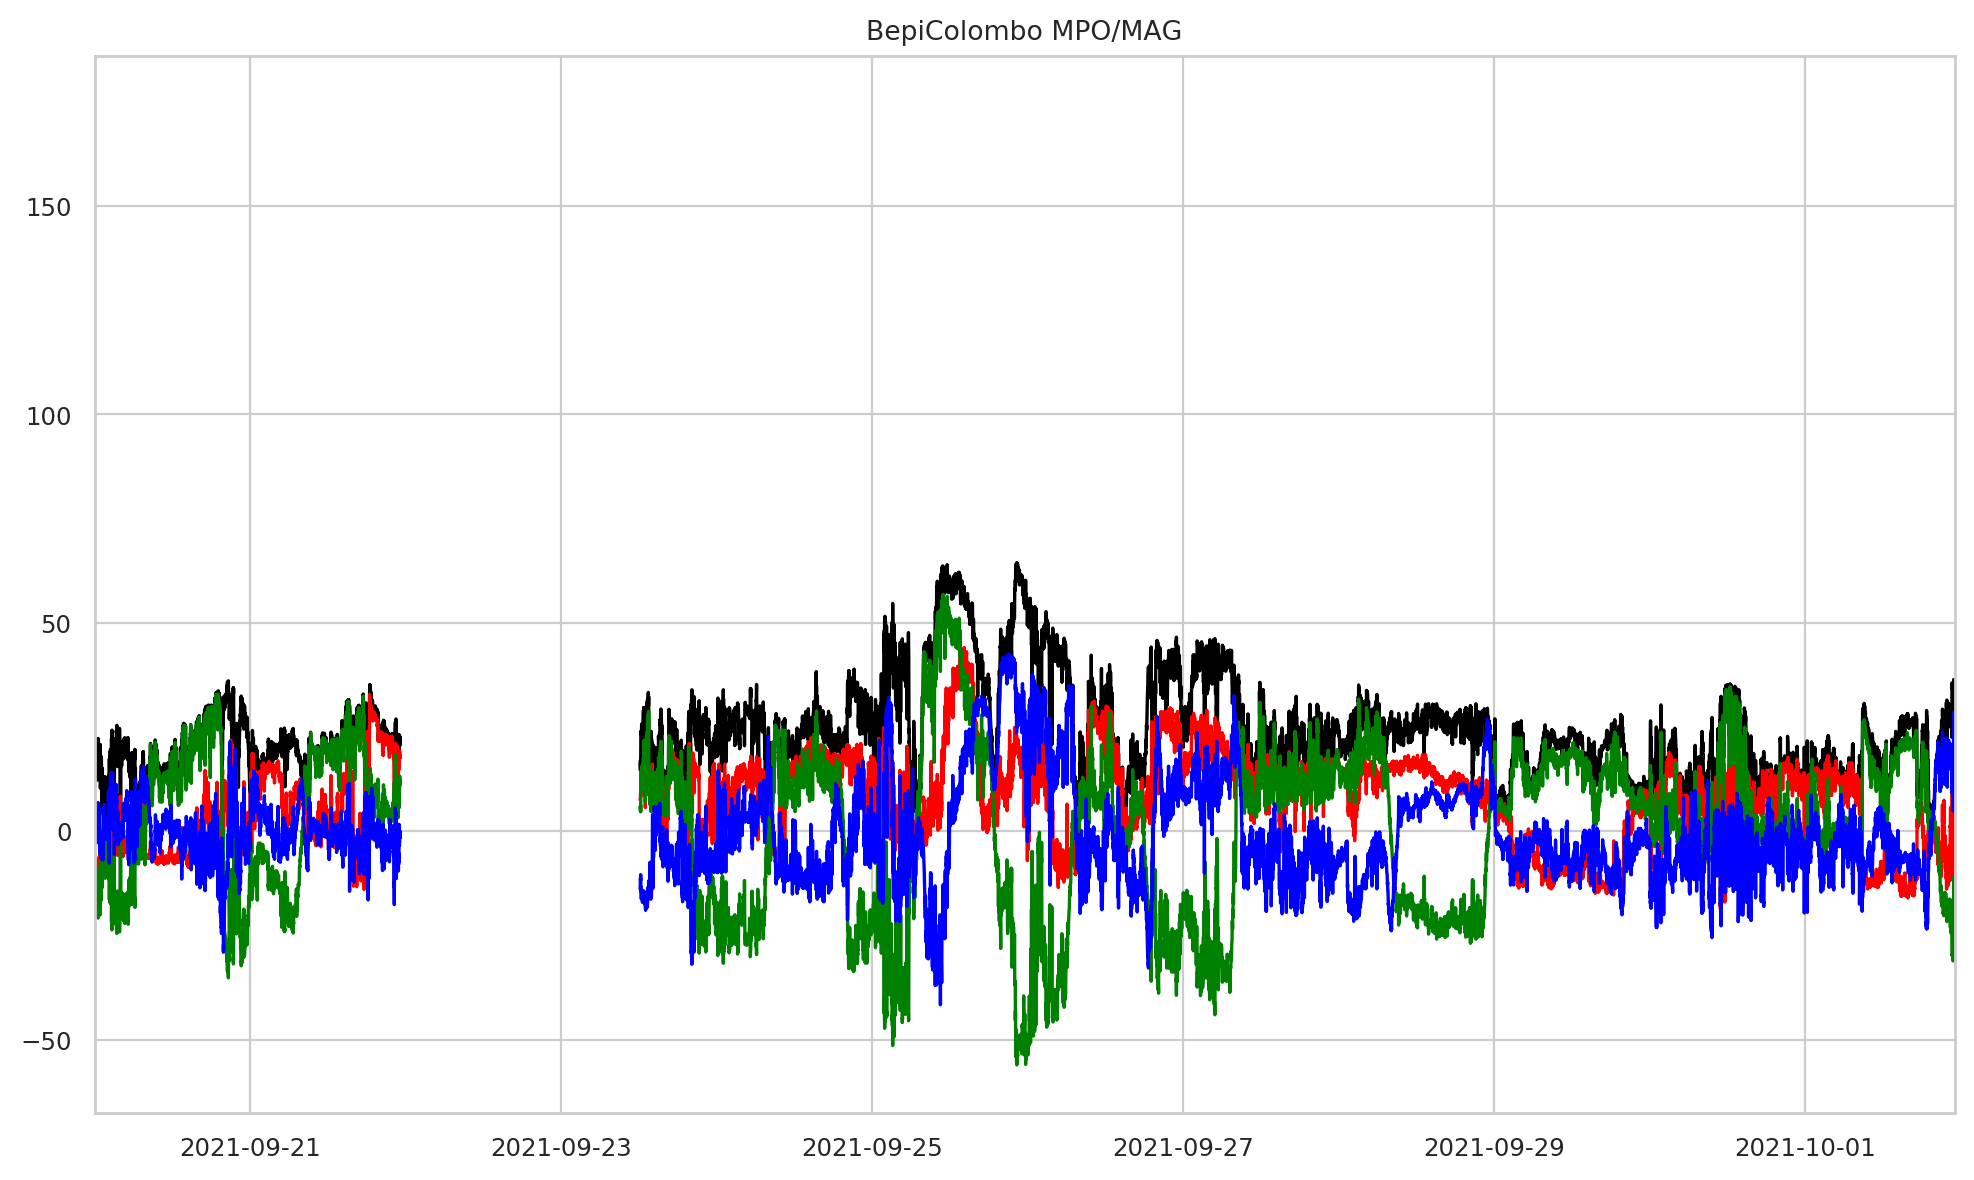

In [3]:
sns.set_style('whitegrid')
sns.set_context('paper')


plt.figure(1,figsize=(12,7),dpi=200)
plt.plot(bmags.time,bmags.bt,color='black')
plt.plot(bmags.time,bmags.bx, color='r')
plt.plot(bmags.time,bmags.by,color='g')
plt.plot(bmags.time,bmags.bz,color='b')
   
    
plotstart=datetime.datetime(2021,9,20,0)
plotend=datetime.datetime(2021,10,1,23)
plt.xlim(plotstart,plotend)
plt.title('BepiColombo MPO/MAG')
plt.savefig('lineups/fall_2021/bepi_icme1.png')

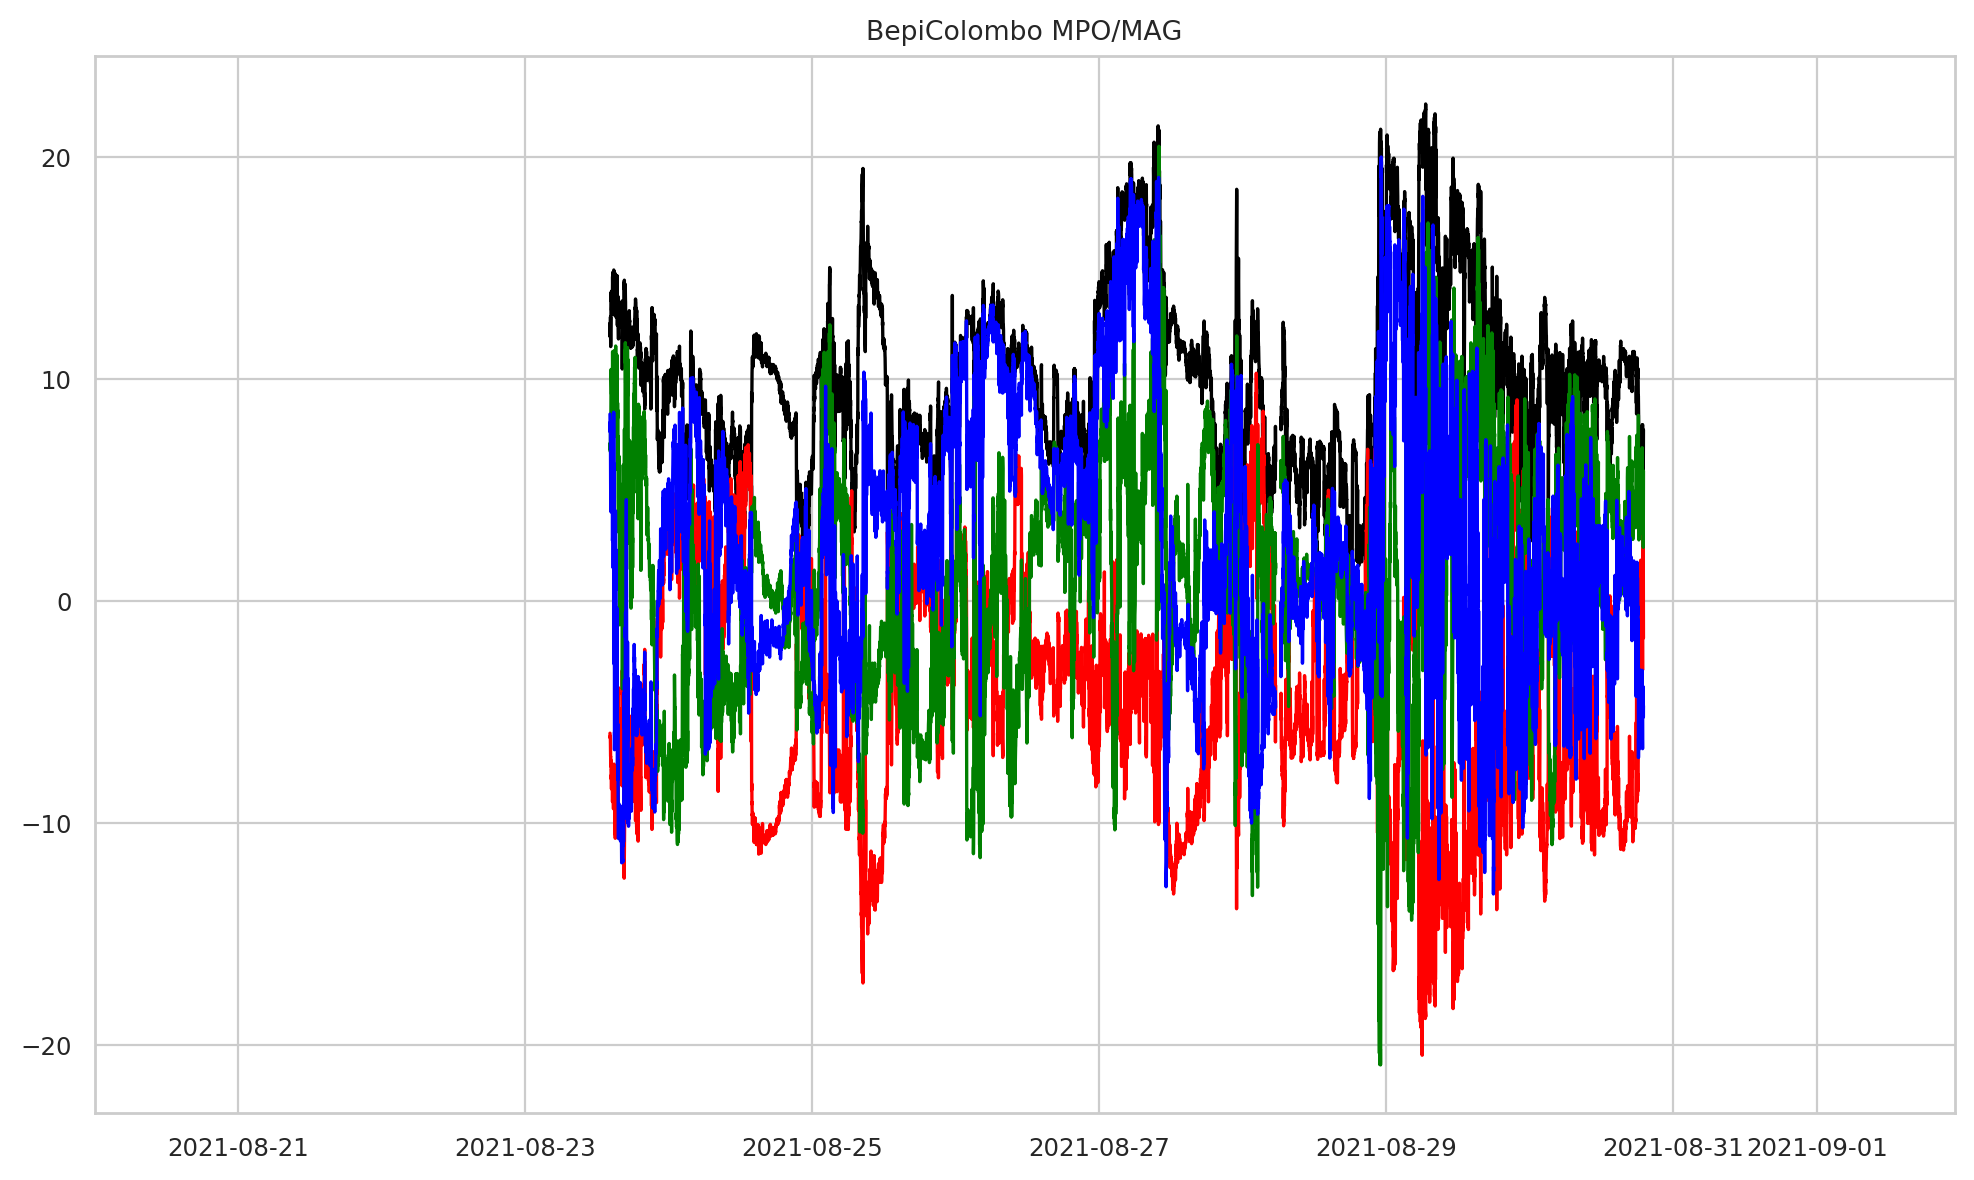

## outbound

In [16]:
#get data from OB SENSOR, ECLIPJ2000

filelist_all=os.listdir(raw_data_path)
#only tab files
filelist = [i for i in filelist_all if i.endswith('.tab')]
filesort=np.sort(filelist)

#start with March 1 2020 
#filesort=filesort[346:]

#set time range for 1 minute interpolation
t_start = datetime.datetime(2019, 3, 6)
t_end = datetime.datetime(2021, 8, 3)

#t_start = datetime.datetime(2020, 10, 6)
#t_end = datetime.datetime(2020, 11, 16)



#make array 
bm=np.zeros(86400*len(filelist),dtype=[('time',object),('bx', float),('by', float),\
        ('bz', float),('x', float),('y', float),('z', float)])  
bm = bm.view(np.recarray) 
               
counter=0            

#x y z
#SC POSITION X COMPONENT, ECLIPJ2000 COORDINATES. VALUE IS GIVEN IN KM. THE SC POSITION IS STATED AS THE DISTANCE TO SUN.
#MAGNETIC FIELD X COMPONENT, 1-SECOND-AVERAGED CALIBRATED DATA,   ECLIPJ2000 COORDINATES, OB SENSOR. VALUE IS GIVEN IN NANOTESLA.

#go through all files
for file in filesort:
    print(file)
    braw=np.loadtxt(raw_data_path+file,delimiter=",",dtype=[('time','<U30'),('tsc','<U30'),('x', float),\
                                            ('y', float),('z', float),('bx', float),('by', float),\
                                            ('bz', float),('t1', float),('t2', float),('t3', float)])
    braw = braw.view(np.recarray) 
            
    bm.time[counter:counter+len(braw)]=parse_time(braw.time).datetime
    bm.bx[counter:counter+len(braw)]=braw.bx
    bm.by[counter:counter+len(braw)]=braw.by
    bm.bz[counter:counter+len(braw)]=braw.bz

    bm.x[counter:counter+len(braw)]=braw.x
    bm.y[counter:counter+len(braw)]=braw.y
    bm.z[counter:counter+len(braw)]=braw.z


    counter=counter+len(braw)

bm1=bm[0:counter]

#------------------------------------------- interpolate to 1 minute

# create an array with 1 minute resolution between t start and end
time = [ t_start + datetime.timedelta(minutes=1*n) for n in range(int ((t_end - t_start).days*60*24))]
time_mat=mdates.date2num(time) 

bmag=np.zeros(np.size(time_mat),dtype=[('time',object),('bx', float),('by', float),\
        ('bz', float),('bt', float),('bxe', float),('bye', float), ('bze', float),\
        ('xe', float),('ye', float),('ze', float),\
        ('x', float),('y', float),('z', float),\
        ('r', float),('lat', float),('lon', float)])  
bmag = bmag.view(np.recarray) 

tm_mat=mdates.date2num(bm1.time) 

bmag.time=time
bmag.bxe = np.interp(time_mat, tm_mat, bm1.bx)
bmag.bye = np.interp(time_mat, tm_mat, bm1.by)
bmag.bze = np.interp(time_mat, tm_mat, bm1.bz)
#bmag.bt =np.sqrt(bmag.bxe**2+bmag.bye**2+bmag.bze**2)




#round first each original time to full minutes
tround=copy.deepcopy(bm1.time)
format_str = '%Y-%m-%d %H:%M'  
for k in np.arange(np.size(bm1.time)):
     tround[k] = datetime.datetime.strptime(datetime.datetime.strftime(bm1.time[k], format_str), format_str) 
tm_round=parse_time(tround).plot_date

isin=np.isin(time_mat,tm_round)      
setnan=np.where(isin==False)
#set to to nan that is not in original data
bmag.bxe[setnan]=np.nan
bmag.bye[setnan]=np.nan
bmag.bze[setnan]=np.nan
bmag.bt = np.sqrt(bmag.bxe**2+bmag.bye**2+bmag.bze**2)




# old with heliopy bepi position in HEEQ
#frame='HEEQ'
#spice.furnish(spicedata.get_kernel('bepi_pred'))
#traheeq=spice.Trajectory('BEPICOLOMBO MPO')
#traheeq.generate_positions(time,'Sun',frame)
#traheeq.change_units(astropy.units.AU)  
#[bmag.r, bmag.lat, bmag.lon]=hd.cart2sphere(traheeq.x,traheeq.y,traheeq.z)

# convert to degree
#bmag.lat=np.rad2deg(bmag.lat)
#bmag.lon=np.rad2deg(bmag.lon)

#bmag.x=traheeq.x.value
#bmag.y=traheeq.y.value
#bmag.z=traheeq.z.value

print('Bepi position')
bepi_pos=heliosat.BEPI().trajectory(time, frame="HEEQ")
bmag.x=bepi_pos[:,0]
bmag.y=bepi_pos[:,1]
bmag.z=bepi_pos[:,2]
[bmag.r, bmag.lat, bmag.lon]=hd.cart2sphere(bepi_pos[:,0],bepi_pos[:,1],bepi_pos[:,2])
bmag.lon=np.rad2deg(bmag.lon) #convert to degree
bmag.lat=np.rad2deg(bmag.lat)


print('done')


####################### save Bepi HEEQ positions and EK2 components data
filemag=data_path+'bepi_2019_2021_e2k.p'
pickle.dump(bmag, open(filemag, "wb"))

mag_der_sc_ob_a001_e2k_00000_20181215.tab
mag_der_sc_ob_a001_e2k_00000_20190306.tab
mag_der_sc_ob_a001_e2k_00000_20190307.tab
mag_der_sc_ob_a001_e2k_00000_20190308.tab
mag_der_sc_ob_a001_e2k_00000_20190309.tab
mag_der_sc_ob_a001_e2k_00000_20190310.tab
mag_der_sc_ob_a001_e2k_00000_20190311.tab
mag_der_sc_ob_a001_e2k_00000_20190312.tab
mag_der_sc_ob_a001_e2k_00000_20190313.tab
mag_der_sc_ob_a001_e2k_00000_20190314.tab
mag_der_sc_ob_a001_e2k_00000_20190315.tab
mag_der_sc_ob_a001_e2k_00000_20190316.tab
mag_der_sc_ob_a001_e2k_00000_20190317.tab
mag_der_sc_ob_a001_e2k_00000_20190318.tab
mag_der_sc_ob_a001_e2k_00000_20190319.tab
mag_der_sc_ob_a001_e2k_00000_20190320.tab
mag_der_sc_ob_a001_e2k_00000_20190321.tab
mag_der_sc_ob_a001_e2k_00000_20190322.tab
mag_der_sc_ob_a001_e2k_00000_20190323.tab
mag_der_sc_ob_a001_e2k_00000_20190324.tab
mag_der_sc_ob_a001_e2k_00000_20190325.tab
mag_der_sc_ob_a001_e2k_00000_20190326.tab
mag_der_sc_ob_a001_e2k_00000_20190327.tab
mag_der_sc_ob_a001_e2k_00000_20190

### convert to all other systems

In [17]:

filemag=data_path+'bepi_2019_2021_e2k.p'
bmag=pickle.load(open(filemag, "rb" ) ) 


######################### convert E2K to HEE
bmage=hd.convert_E2K_to_HEE(bmag)
filemag=data_path+'bepi_2019_2021_hee.p'
pickle.dump(bmage, open(filemag, "wb"))


######################### convert HEE to HEEQ
bmagq=hd.convert_HEE_to_HEEQ(bmage)
filemag=data_path+'bepi_2019_2021_heeq.p'
pickle.dump(bmagq, open(filemag, "wb"))


######################### convert HEEQ to RTN

bmagrtn=hd.convert_HEEQ_to_RTN(bmagq)
filemag=data_path+'bepi_2019_2021_rtn.p'
pickle.dump(bmagrtn, open(filemag, "wb"))


######################### convert HEEQ to SCEQ
bmags=hd.convert_HEEQ_to_SCEQ(bmagq)
filemag=data_path+'bepi_2019_2021_sceq.p'
pickle.dump(bmags, open(filemag, "wb"))


print('all done')

conversion E2K to HEE
conversion HEE to HEEQ
HEE to HEEQ done
conversion HEEQ to RTN
conversion HEEQ to RTN done
HEEQ to SCEQ
all done


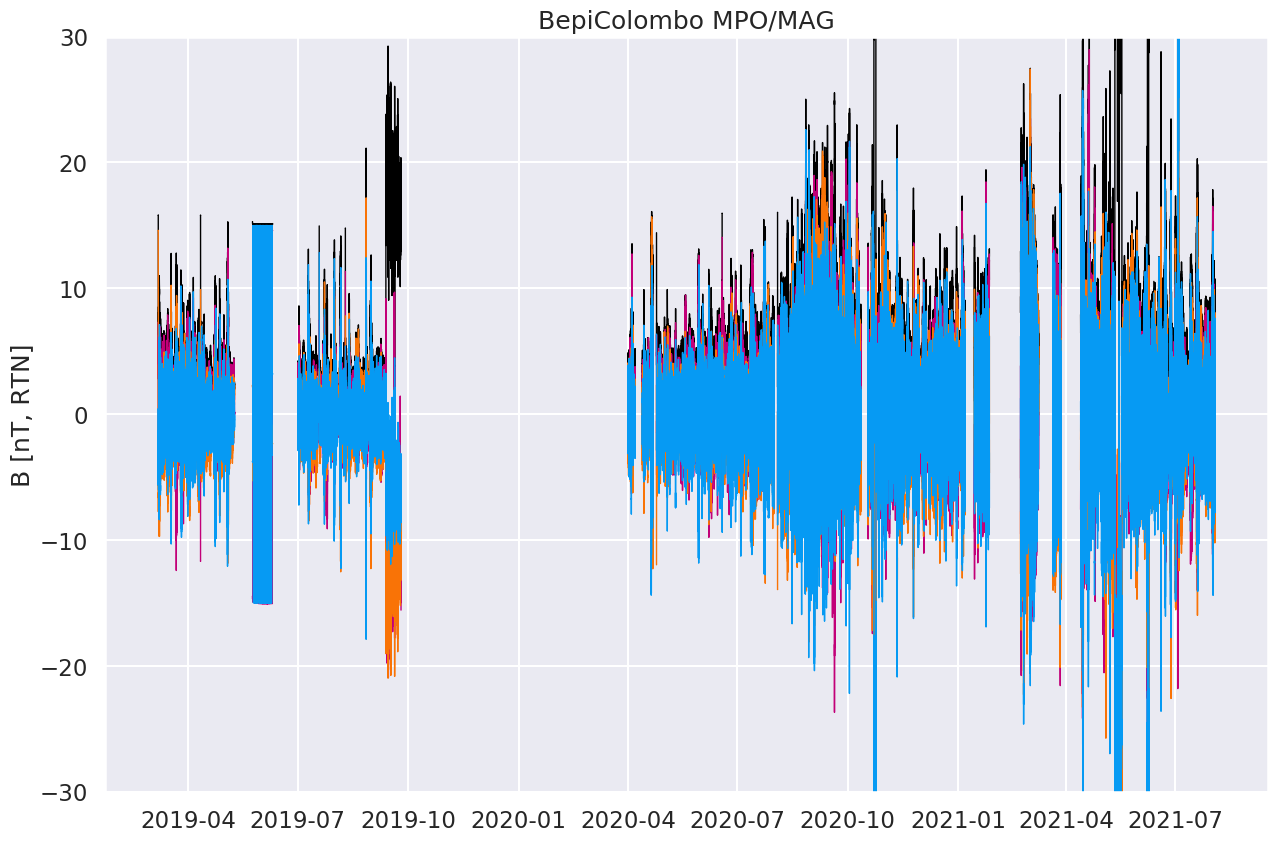

In [18]:
#filemag='data/bepi_2020_march_sept_e2k.p'
#filemag=data_path+'bepi_2019_2020_rtn.p'
filemag=data_path+'bepi_2019_2021_e2k.p'
bm=pickle.load(open(filemag, "rb" ) ) 


%matplotlib inline

sns.set_context("talk")     
sns.set_style('darkgrid')

plt.figure(1,figsize=(15, 10),dpi=100)

ax = plt.subplot(111)
plt.title('BepiColombo MPO/MAG')
ax.plot(bm.time, bm.bt, "k-", lw=1, label='Btotal')
ax.plot(bm.time, bm.bxe, "r-", color="xkcd:magenta", lw=1, label='Br')
ax.plot(bm.time, bm.bye, "g-", color="xkcd:orange", lw=1,label='Bt')
ax.plot(bm.time, bm.bze, "b-", color="xkcd:azure", lw=1,label='Bn')
plt.ylabel('B [nT, RTN]')
ax.set_ylim([-30,30])
#ax.legend()


#plt.tight_layout()



plt.savefig('results/bepi_cruise.png',dpi=100)


## extra files for April 2020 CME

In [6]:
#OB SENSOR, ECLIPJ2000

filelist=[raw_data_path+'mag_der_sc_ob_a001_e2k_00000_20200415.tab',
          raw_data_path+'mag_der_sc_ob_a001_e2k_00000_20200416.tab',
          raw_data_path+'mag_der_sc_ob_a001_e2k_00000_20200417.tab',
          raw_data_path+'mag_der_sc_ob_a001_e2k_00000_20200418.tab',
          raw_data_path+'mag_der_sc_ob_a001_e2k_00000_20200419.tab',
          raw_data_path+'mag_der_sc_ob_a001_e2k_00000_20200420.tab',
          raw_data_path+'mag_der_sc_ob_a001_e2k_00000_20200421.tab',]
#          'data/bepi_mag_cruise/mag_der_sc_ob_a001_e2k_00000_20200424.tab',
#          'data/bepi_mag_cruise/mag_der_sc_ob_a001_e2k_00000_20200425.tab']


#make array 
bm=np.zeros(86400*len(filelist),dtype=[('time',object),('bx', float),('by', float),\
        ('bz', float),('x', float),('y', float),('z', float)])  
bm = bm.view(np.recarray) 
               
counter=0            

#x y z
#SC POSITION X COMPONENT, ECLIPJ2000 COORDINATES. VALUE IS GIVEN IN KM. THE SC POSITION IS STATED AS THE DISTANCE TO SUN.
#MAGNETIC FIELD X COMPONENT, 1-SECOND-AVERAGED CALIBRATED DATA,   ECLIPJ2000 COORDINATES, OB SENSOR. VALUE IS GIVEN IN NANOTESLA.

#go through all files
for file in filelist:
    print(file)
    braw=np.loadtxt(file,delimiter=",",dtype=[('time','<U30'),('tsc','<U30'),('x', float),\
                                            ('y', float),('z', float),('bx', float),('by', float),\
                                            ('bz', float),('t1', float),('t2', float),('t3', float)])
    braw = braw.view(np.recarray) 
            

    bm.time[counter:counter+len(braw)]=parse_time(braw.time).datetime
    bm.bx[counter:counter+len(braw)]=braw.bx
    bm.by[counter:counter+len(braw)]=braw.by
    bm.bz[counter:counter+len(braw)]=braw.bz

    bm.x[counter:counter+len(braw)]=braw.x
    bm.y[counter:counter+len(braw)]=braw.y
    bm.z[counter:counter+len(braw)]=braw.z


    counter=counter+len(braw)

bm1=bm[0:counter]

#interpolate to 1 minute
t_start = datetime.datetime(2020, 4, 15)
t_end = datetime.datetime(2020, 4, 22)

# create an array with 1 minute resolution between t start and end
time = [ t_start + datetime.timedelta(minutes=1*n) for n in range(int ((t_end - t_start).days*60*24))]
time_mat=mdates.date2num(time) 

bmag=np.zeros(np.size(time_mat),dtype=[('time',object),('bx', float),('by', float),\
        ('bz', float),('bt', float),('bxe', float),('bye', float), ('bze', float),\
        ('xe', float),('ye', float),('ze', float),\
        ('x', float),('y', float),('z', float),\
        ('r', float),('lat', float),('lon', float)])  
bmag = bmag.view(np.recarray) 

tm_mat=mdates.date2num(bm1.time) 

bmag.time=time
bmag.bxe = np.interp(time_mat, tm_mat, bm1.bx)
bmag.bye = np.interp(time_mat, tm_mat, bm1.by)
bmag.bze = np.interp(time_mat, tm_mat, bm1.bz)
bmag.bt =np.sqrt(bmag.bxe**2+bmag.bye**2+bmag.bze**2)


## position
#frame='ECLIPJ2000'
#spice.furnish(spicedata.get_kernel('bepi_pred'))
#tra=spice.Trajectory('BEPICOLOMBO MPO')
#tra.generate_positions(time,'Sun',frame)
#tra.change_units(astropy.units.AU)  
#[bmag.r, bmag.lat, bmag.lon]=hd.cart2sphere(tra.x,tra.y,tra.z)


## bepi position in HEEQ
frame='HEEQ'
spice.furnish(spicedata.get_kernel('bepi_pred'))
traheeq=spice.Trajectory('BEPICOLOMBO MPO')
traheeq.generate_positions(time,'Sun',frame)
traheeq.change_units(astropy.units.AU)  
[bmag.r, bmag.lat, bmag.lon]=hd.cart2sphere(traheeq.x,traheeq.y,traheeq.z)


#convert to degree
bmag.lat=np.rad2deg(bmag.lat)
bmag.lon=np.rad2deg(bmag.lon)

bmag.x=traheeq.x.value
bmag.y=traheeq.y.value
bmag.z=traheeq.z.value

#E2K position from data files
#bmag.xe = np.interp(time_mat, tm_mat, bm1.x/AU)
#bmag.ye = np.interp(time_mat, tm_mat, bm1.y/AU)
#bmag.ze = np.interp(time_mat, tm_mat, bm1.z/AU)

#print('bepi position eclipj2000 x y z mean AU from heliopy:')
#print(np.mean(bmag.x))
#print(np.mean(bmag.y))
#print(np.mean(bmag.z))

#print('bepi position eclipj2000 x y z mean AU from data files:')
#print(np.mean(bmag.xe))
#print(np.mean(bmag.ye))
#print(np.mean(bmag.ze))


filemag=data_path+'bepi_2020_icme_april_e2k.p'
pickle.dump(bmag, open(filemag, "wb"))


print('read done')

/nas/helio/data/BepiColombo/cruise_ob/mag_der_sc_ob_a001_e2k_00000_20200415.tab
/nas/helio/data/BepiColombo/cruise_ob/mag_der_sc_ob_a001_e2k_00000_20200416.tab
/nas/helio/data/BepiColombo/cruise_ob/mag_der_sc_ob_a001_e2k_00000_20200417.tab
/nas/helio/data/BepiColombo/cruise_ob/mag_der_sc_ob_a001_e2k_00000_20200418.tab
/nas/helio/data/BepiColombo/cruise_ob/mag_der_sc_ob_a001_e2k_00000_20200419.tab
/nas/helio/data/BepiColombo/cruise_ob/mag_der_sc_ob_a001_e2k_00000_20200420.tab
/nas/helio/data/BepiColombo/cruise_ob/mag_der_sc_ob_a001_e2k_00000_20200421.tab
read done


### convert to all other systems

In [7]:
from heliocats import data as hd
importlib.reload(hd) #reload again while debugging


filemag=data_path+'bepi_2020_icme_april_e2k.p'
bmag=pickle.load(open(filemag, "rb" ) ) 

######################### convert E2K to HEE
bmage=hd.convert_E2K_to_HEE(bmag)
filemag=data_path+'bepi_2020_icme_april_hee.p'
pickle.dump(bmage, open(filemag, "wb"))


######################### convert HEE to HEEQ
bmagq=hd.convert_HEE_to_HEEQ(bmage)
filemag=data_path+'bepi_2020_icme_april_heeq.p'
pickle.dump(bmagq, open(filemag, "wb"))


######################### convert HEEQ to RTN
bmagrtn=hd.convert_HEEQ_to_RTN(bmagq)
filemag=data_path+'bepi_2020_icme_april_rtn.p'
pickle.dump(bmagrtn, open(filemag, "wb"))

#save as txt
np.savetxt('data/bepi_2020_icme_april_rtn.txt',bmagrtn,header='time, bx [RTN,nT],\
           by [RTN,nT], bz [RTN,nT], bt [nT], bxe [EJ2000,nT], bye [EJ2000,nT], \
           bze [EJ2000,nT],  xe [EJ2000, AU], ye [EJ2000, AU], ze [EJ2000, AU], \
           x [HEEQ, AU], y [HEEQ, AU], z [HEEQ, AU], r [AU], lat [HEEQ,deg], \
           lon [HEEQ,deg]',fmt='%16s %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e ')


######################### convert HEEQ to GSE for consistency check
#bmaggse=hd.convert_HEEQ_to_GSE(bmagq)
#filemag=data_path+'bepi_april2020_icme_gse.p'
#pickle.dump(bmaggse, open(filemag, "wb"))


print('all done')

conversion E2K to HEE
conversion HEE to HEEQ
HEE to HEEQ done
conversion HEEQ to RTN
conversion HEEQ to RTN done
all done


## Plot data

In [8]:
#filemag='data/bepi_2020_march_sept_e2k.p'
filemag=data_path+'bepi_april2020_icme_heeq.p'
bmagq=pickle.load(open(filemag, "rb" ) ) 

filemag=data_path+'bepi_april2020_icme_rtn.p'
bmagrtn=pickle.load(open(filemag, "rb" ) ) 

filemag=data_path+'bepi_april2020_icme_hee.p'
bmaghee=pickle.load(open(filemag, "rb" ) ) 

filemag=data_path+'bepi_april2020_icme_gse.p'
bmaggse=pickle.load(open(filemag, "rb" ) ) 

filewin=data_path+'wind_2018_2020_oct_gse.p'
[win,hwin]=pickle.load(open(filewin, "rb" ) )

#%matplotlib  inline
%matplotlib 


sns.set_context("paper")     
sns.set_style('darkgrid')

plt.figure(1, figsize=(12,12), dpi=100)

ax1 = plt.subplot(311) 
ax1.plot_date(bmaghee.time,bmaghee.bt,'k-',label='Bepi HEE')
ax1.plot_date(bmaghee.time,bmaghee.bx,'r-')
ax1.plot_date(bmaghee.time,bmaghee.by,'g-')
ax1.plot_date(bmaghee.time,bmaghee.bz,'b-')

#ax1.plot_date(bmaggse.time,bmaggse.bt,'k-',label='from GSE')
#ax1.plot_date(bmaggse.time,-bmaggse.bx,'r-')
#ax1.plot_date(bmaggse.time,-bmaggse.by,'g-')
#ax1.plot_date(bmaggse.time,bmaggse.bz,'b-')

ax1.legend()

ax1.set_ylabel('B [nT]')
ax1.set_title('Bepi Colombo MPO/MAG')
ax1.set_ylim(-20,20)


ax2 = plt.subplot(312,sharex = ax1) 
ax2.plot_date(win.time,win.bt,'k-',label='Wind HEE')
ax2.plot_date(win.time,-win.bx,'r-')
ax2.plot_date(win.time,-win.by,'g-')
ax2.plot_date(win.time,win.bz,'b-')


bmaghee.time=bmaghee.time+timedelta(hours=-1.9)

ax2.plot_date(bmaghee.time,bmaghee.bt,'k--',label='Bepi HEE')
ax2.plot_date(bmaghee.time,bmaghee.bx,'r--')
ax2.plot_date(bmaghee.time,bmaghee.by,'g--')
ax2.plot_date(bmaghee.time,bmaghee.bz,'b--')

ax2.set_ylabel('B [nT]')
ax2.set_title('Wind MFI')
ax2.set_ylim(-20,20)

ax2.legend()


ax3 = plt.subplot(313,sharex = ax1) 
ax3.plot_date(win.time,win.vt,'k-')
ax3.set_ylabel('V [km/s]')
ax3.set_title('Wind SWE')



#all
plotstart=datetime.datetime(2020, 4, 19)
plotend=datetime.datetime(2020, 4,22)
ax1.set_xlim(plotstart,plotend)
ax2.set_xlim(plotstart,plotend)
ax3.set_xlim(plotstart,plotend)




plt.tight_layout()

#[earth_r, earth_lat, earth_lon]=hd.cart2sphere(earth.x,earth.y,earth.z)
#l1_r=np.mean(earth_r)-0.01
#bepi_r=np.mean(bmag.r)
#print('L1 at AU ',l1_r)
#print('bepi at AU ',bepi_r)
#print('diff', l1_r-bepi_r)
#print('time delay for 350 km/s in minutes', (l1_r-bepi_r)*AU/(350*60))
#print('bepi at longitude',np.mean(bmag.lon))

FileNotFoundError: [Errno 2] No such file or directory: '/nas/helio/data/insitu_python/bepi_april2020_icme_heeq.p'

### component plot with time shift

In [ ]:
filemag=data_path+'bepi_april2020_icme_hee.p'
be=pickle.load(open(filemag, "rb" ) ) 

#time shift
be.time=be.time+timedelta(hours=-2)

sns.set_context("talk")     
sns.set_style('darkgrid')

plt.figure(5, figsize=(12,9), dpi=100)

#------------------------------ Bt
ax1 = plt.subplot(411) 
plt.title('Bepi Colombo MPO/MAG with time shift, Wind MFI ')
ax1.plot_date(be.time, be.bt,'-k',label='Bepi Colombo', linewidth=1)
ax1.plot_date(win.time, win.bt,'--k',linewidth=1,label='Wind')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel('Bt [nT]')
ax1.legend(loc=2)
ax1.set_ylim((0, 20))

#reverse win.bx and win.by for plotting GSE to HEE

ax2 = plt.subplot(412,sharex=ax1) 
ax2.plot_date(be.time, be.bx,'-r',label='Bepi Colombo',linewidth=1)
#ax2.plot_date(bm.time, bm.bxe,'-r',label='Bx',linewidth=3)
ax2.plot_date(win.time, -win.bx,'--r',linewidth=1,label='Wind')
plt.setp(ax2.get_xticklabels(), visible=False)
plt.ylabel('Bx [nT], HEE')
ax2.set_ylim((-18, 18))

ax3 = plt.subplot(413,sharex=ax1) 
ax3.plot_date(be.time, be.by,'-g',label='Bepi Colombo',linewidth=1)
#ax3.plot_date(bm.time, bm.bye,'-g',label='By',linewidth=3)
ax3.plot_date(win.time, -win.by,'--g',linewidth=1, label='Wind')
plt.setp(ax3.get_xticklabels(), visible=False)
plt.ylabel('By [nT], HEE')
ax3.set_ylim((-18, 18))

ax4 = plt.subplot(414,sharex=ax1) 
ax4.plot_date(be.time, be.bz,'-b',label='Bepi Colombo',linewidth=1)
#ax4.plot_date(bm.time, bm.bze,'-b',label='Bz',linewidth=3)
ax4.plot_date(win.time, win.bz,'--b',linewidth=1, label='Wind')
plt.ylabel('Bz [nT], HEE')
ax4.set_ylim((-18, 18))


#all
plotstart=datetime.datetime(2020, 4, 19)
plotend=datetime.datetime(2020, 4,22)
plt.xlim(plotstart,plotend)


#shock
#plotstart=datetime.datetime(2020, 4, 20,0,0)
#plotend=datetime.datetime(2020, 4,20,4,0)
#plt.xlim(plotstart,plotend)

plt.tight_layout()


plt.savefig('results/bepi_cme_april2020_hee.png',dpi=300)

# CME 2 May 2020

## Plot CME 2 May 2020

In [ ]:
plt.figure(10)

filemag=data_path+'bepi_2019_2020_hee.p'
be=pickle.load(open(filemag, "rb" ) ) 

#time shift
be.time=be.time+timedelta(hours=13)


#all
plotstart=datetime.datetime(2020, 5, 28)
plotend=datetime.datetime(2020, 6,1)


sns.set_context("talk")     
sns.set_style('darkgrid')


plt.figure(1, figsize=(12,9), dpi=100)

#------------------------------ Bt
ax1 = plt.subplot(411) 
plt.title('Bepi Colombo MPO/MAG, Wind MFI')
ax1.plot_date(be.time, be.bt,'-k',label='Bepi Colombo', linewidth=1)
ax1.plot_date(win.time, win.bt,'--k',linewidth=1,label='Wind')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel('Bt [nT]')
ax1.legend(loc=2)
ax1.set_ylim((0, 20))

#reverse win.bx and win.by for plotting GSE to HEE

ax2 = plt.subplot(412,sharex=ax1) 
ax2.plot_date(be.time, be.bx,'-r',label='Bepi Colombo',linewidth=1)
#ax2.plot_date(bm.time, bm.bxe,'-r',label='Bx',linewidth=3)
ax2.plot_date(win.time, -win.bx,'--r',linewidth=1,label='Wind')
plt.setp(ax2.get_xticklabels(), visible=False)
plt.ylabel('Bx [nT], HEE')
ax2.set_ylim((-18, 18))

ax3 = plt.subplot(413,sharex=ax1) 
ax3.plot_date(be.time, be.by,'-g',label='Bepi Colombo',linewidth=1)
#ax3.plot_date(bm.time, bm.bye,'-g',label='By',linewidth=3)
ax3.plot_date(win.time, -win.by,'--g',linewidth=1, label='Wind')
plt.setp(ax3.get_xticklabels(), visible=False)
plt.ylabel('By [nT], HEE')
ax3.set_ylim((-18, 18))



#position on figure
textstart=plotstart+datetime.timedelta(hours=2)
ax3.text(textstart,10,'Bepi HEE R/lat/lon: '+str(np.round(np.mean(be.r),3))+' ' +str(np.round(np.mean(be.lat),2))+'  '+\
         str(np.round(np.mean(be.lon),2)),fontsize=13)



ax4 = plt.subplot(414,sharex=ax1) 
ax4.plot_date(be.time, be.bz,'-b',label='Bepi Colombo',linewidth=1)
#ax4.plot_date(bm.time, bm.bze,'-b',label='Bz',linewidth=3)
ax4.plot_date(win.time, win.bz,'--b',linewidth=1, label='Wind')
plt.ylabel('Bz [nT], HEE')
ax4.set_ylim((-18, 18))



plt.xlim(plotstart,plotend)


#shock
#plotstart=datetime.datetime(2020, 4, 20,0,0)
#plotend=datetime.datetime(2020, 4,20,4,0)
#plt.xlim(plotstart,plotend)

plt.tight_layout()


plt.savefig('results/bepi_cme_may2020_shift13.png')



### for HELIOSAT new version 


#other checks
#------------------------------------------ add position
frame='ECLIPJ2000'
spice.furnish(spicedata.get_kernel('bepi_pred'))
tra=spice.Trajectory('BEPICOLOMBO MPO')
tra.generate_positions(time,'Sun',frame)
tra.change_units(astropy.units.AU)  
[bepi_r_ej2, bepi_lat_ej2, bepi_lon_ej2]=hd.cart2sphere(tra.x,tra.y,tra.z)


#----------------------- make bepi position in HEE
frame='HEE'
spice.furnish(spicedata.get_kernel('bepi_pred'))
trahee=spice.Trajectory('BEPICOLOMBO MPO')
trahee.generate_positions(time,'Sun',frame)
trahee.change_units(astropy.units.AU)  
[bepi_r_hee, bepi_lat_hee, bepi_lon_hee]=hd.cart2sphere(trahee.x,trahee.y,trahee.z)


#put values into array
bmag.r=bepi_r_hee
#convert to degree
bmag.lat=np.rad2deg(bepi_lat_hee)
bmag.lon=np.rad2deg(bepi_lon_hee)

bmag.x=trahee.x.value
bmag.y=trahee.y.value
bmag.z=trahee.z.value

#E2K position from data files
bmag.xe = np.interp(time_mat, tm_mat, bm1.x/AU)
bmag.ye = np.interp(time_mat, tm_mat, bm1.y/AU)
bmag.ze = np.interp(time_mat, tm_mat, bm1.z/AU)



##################################################
print('bepi position eclipj2000 x y z mean AU from heliopy:')
print(np.mean(bmag.x))
print(np.mean(bmag.y))
print(np.mean(bmag.z))

print('bepi position eclipj2000 x y z mean AU from data files:')
print(np.mean(bmag.xe))
print(np.mean(bmag.ye))
print(np.mean(bmag.ze))


print('bepi position HEE x y z mean AU from heliopy:')
print(np.mean(trahee.x))
print(np.mean(trahee.y))
print(np.mean(trahee.z))


In [9]:
# bepi example
DATAPATH = "/nas/helio/data/BepiColombo/cruise_ob"
class BEPI_EXT(heliosat.BEPI):
    def get_data_files(self, *args):
        files = os.listdir(DATAPATH)
        files.sort()
        files = [os.path.join(DATAPATH, f) for f in files if f[-3:] == "tab"]
        range_start, range_end, data_key = args
        if range_end < range_start:
            raise ValueError("starting date must be after final date")
        data_key = self.resolve_data_key(data_key)
        # adjust ranges slightly
        range_start -= datetime.timedelta(hours=range_start.hour, minutes=range_start.minute,
                                          seconds=range_start.second)
        if range_end.hour == 0 and range_end.minute == 0 and range_end.second == 0:
            range_end -= datetime.timedelta(seconds=1)
        # filter out files
        # get date for each file
        files_dates = np.array([
            datetime.datetime.strptime(os.path.basename(_)[:-4][-8:], "%Y%m%d") for _ in files
        ])
        mask = (files_dates > range_start) & (files_dates < range_end)
        files_selected = np.array(files)[mask]
        files_selected_dates = np.array(files_dates)[mask]
        return files_selected, [self.get_data_version("mag", _) for _ in files_selected_dates]
_t = [datetime.datetime(2020, 4, 19) + datetime.timedelta(hours=0, minutes=15*i) for i in range(0, 4 * 24 * 3)]
bepi_t, bepi_b = BEPI_EXT().get_data(_t, "mag", frame="HEE", smoothing="kernel",
                                    smoothing_scale=240, cache=False, remove_nans=True, return_datetimes=True)
#BC_MPO_RTN          MPO Radial-Tangential-Normal Heliocentric
#BC_MMO_RTN          MMO Radial-Tangential-Normal Heliocentric (bearbeitet) 

Process ForkProcess-2:


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/cmoestl/miniconda/envs/helio/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/cmoestl/miniconda/envs/helio/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/cmoestl/miniconda/envs/helio/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/cmoestl/miniconda/envs/helio/lib/python3.7/multiprocessing/queues.py", line 94, in get
    res = self._recv_bytes()
  File "/home/cmoestl/miniconda/envs/helio/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/cmoestl/miniconda/envs/helio/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/cmoestl/miniconda/envs/helio/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    